In [1]:
import matplotlib.pyplot as plt
from tueplots import bundles
import numpy as np
from rapidresponsebench.utils.data import RESULT


def plot_ticks(ticks):
    res = []
    for i in ticks:
        i = str(i)
        if '/' in i:
            i = i.split('/')[-1]
        res.append(i)
    return res

raw_results = RESULT.list()

RESPONSES = ['guardfinetuning', 'regex', 'embedding', 'guardfewshot', 'defenseprompt']
LEGEND_LABELS = ['Guard Fine-tuning', 'Regex', 'Embedding', 'Guard Few-shot', 'Defense Prompt']  # New line

RESPONSE_TO_LABEL = {i:j for i, j in zip(RESPONSES, LEGEND_LABELS)}


In [9]:
plt.rcParams.update(bundles.iclr2024())

{'response': 'defenseprompt', 'attacks': ['cipher', 'crescendo', 'msj', 'pair', 'renellm', 'skeleton_key'], 'model': 'mistralai/Mistral-7B-Instruct-v0.2', 'shots': 25, 'proliferation_model': 'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo', 'proliferation_compute_fraction': 1.0, 'proliferation_top_p': 1.0, 'proliferation_temperature': 1.0}
{'response': 'defenseprompt', 'attacks': ['cipher', 'crescendo', 'msj', 'pair', 'renellm', 'skeleton_key'], 'model': 'mistralai/Mistral-7B-Instruct-v0.2', 'shots': 5, 'proliferation_model': 'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo', 'proliferation_compute_fraction': 1.0, 'proliferation_top_p': 1.0, 'proliferation_temperature': 1.0}
{'response': 'defenseprompt', 'attacks': ['cipher', 'crescendo', 'msj', 'pair', 'renellm', 'skeleton_key'], 'model': 'mistralai/Mistral-7B-Instruct-v0.2', 'shots': 0, 'proliferation_model': 'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo', 'proliferation_compute_fraction': 1.0, 'proliferation_top_p': 1.0, 'proliferation_t

/tmp/ipykernel_324730/3706201.py:116: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


done layout
done adjust
done show


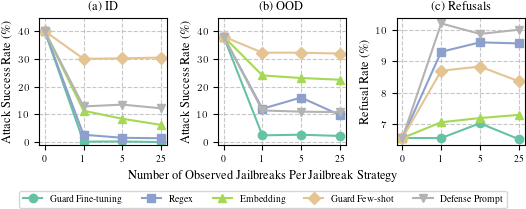

In [43]:
def clean_name(response):
    if response == "guardfinetuning":
        return "Guard Fine-tuning"
    

def fig1():

    PROLIFERATION_MODEL = 'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo'
    SHOTS = [0, 1, 5, 25]

    data = []
    for result in raw_results:
        p = result.params
        if p['proliferation_top_p'] != 1.0 or p['proliferation_temperature'] != 1.0 or p['proliferation_model'] != PROLIFERATION_MODEL or p['proliferation_compute_fraction'] != 1.0:
            continue
        rj = result.json()
        print(p)
        def avg_asr(suffix):
            num = 0
            denom = 0
            for k, v in rj.items():
                if k.endswith(suffix):
                    num += v['asr']
                    denom += 1
            return num / denom

        data.append(
            {
                'response': p['response'],
                'shots': p['shots'],
                'iid': avg_asr('_iid'),
                'ood': avg_asr('_ood'),
                'refusal_rate': rj['easy_refusal_rate']
            }
        )
        
    print(len(data))

    RESPONSES = ['guardfinetuning', 'regex', 'embedding', 'guardfewshot', 'defenseprompt']
    organized_data = {response: {value: [] for value in SHOTS} for response in RESPONSES}
    for item in data:
        organized_data[item['response']][item['shots']].append(item)

    # Calculate average ASR for IID and OOD attacks
    avg_data = {response: {} for response in RESPONSES}
    for response in RESPONSES:
        for param_value, items in organized_data[response].items():
            if items:

                def avg_over_keys(key):
                    return sum(i[key] for i in items) / len(items)

                avg_data[response][param_value] = {
                    'iid': avg_over_keys('iid'),
                    'ood': avg_over_keys('ood'),
                    'refusal_rate': avg_over_keys('refusal_rate')
                }

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5.5, 2.25))
    colors = plt.cm.Set2(np.linspace(0, 1, len(RESPONSES)))
    markers = ['o', 's', '^', 'D', 'v']

    # Create equidistant x-axis values
    x_equidistant = range(len(SHOTS))

    for i, response in enumerate(RESPONSES):
        color = colors[i]
        marker = markers[i]

        # 1. IID line graph
        iid_y = [avg_data[response].get(x, {}).get('iid', np.nan) * 100 for x in SHOTS]
        print('iid', response, iid_y)
        ax1.plot(x_equidistant, iid_y, color=color, linestyle='-', marker=marker,
                 markersize=6, linewidth=1.5, label=RESPONSE_TO_LABEL[response])

        # 2. OOD line graph
        ood_y = [avg_data[response].get(x, {}).get('ood', np.nan) * 100 for x in SHOTS]
        ax2.plot(x_equidistant, ood_y, color=color, linestyle='-', marker=marker,
                 markersize=6, linewidth=1.5, label=RESPONSE_TO_LABEL[response])

        print('ood', response, ood_y)
        
        # 3. Refusal rate line graph
        refusal_y = [avg_data[response].get(x, {}).get('refusal_rate', np.nan) * 100 for x in SHOTS]
        print('refusal', response, refusal_y)
        ax3.plot(x_equidistant, refusal_y, color=color, linestyle='-', marker=marker,
                 markersize=6, linewidth=1.5, label=RESPONSE_TO_LABEL[response])

    # Customize each subplot
    for ax, title, metric, ylabel in zip(
            [ax1, ax2, ax3],
            ['(a) ID', '(b) OOD', '(c) Refusals'],
            ['iid', 'ood', 'refusal_rate'],
            ['Attack Success Rate (\%)',' Attack Success Rate (\%)', "Refusal Rate (\%)"]
    ):
        print("customize", title, metric, ylabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.set_xticks(x_equidistant)
        ax.set_xticklabels(SHOTS)

        if metric == "iid" or metric == "ood":
            ax.set_ylim(-1, 45)

        ax.grid(True, linestyle='--', alpha=0.7)

    # Add a single legend for all subplots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(RESPONSES), bbox_to_anchor=(0.5, 0))
    print("done legend")

    # Add a common x-label for all subplots
    fig.text(0.5, 0.15, 'Number of Observed Jailbreaks Per Jailbreak Strategy', ha='center')
    print("done text")

    fig.tight_layout()
    print("done layout")
    fig.subplots_adjust(bottom=0.3)  # Adjust to make room for the legend and x-label
    print("done adjust")
    print("done show")
    fig.savefig(f"plots/shots.png",  bbox_inches='tight', dpi=300)
    # print("done save")

fig1()

75
guardfinetuning [2.166666666666667, 2.416666666666667, 1.916666666666667, 1.3055555555555556, 1.2777777777777777]
120
guardfinetuning [12.027777777777777, 2.2222222222222223, 2.055555555555556, 1.6388888888888886, 1.9722222222222223, 1.6388888888888886, 1.6944444444444446, 1.3055555555555556]
regex [14.833333333333334, 7.750000000000002, 6.861111111111111, 10.194444444444445, 12.694444444444445, 8.277777777777777, 9.277777777777779, 7.361111111111112]
embedding [27.861111111111114, 19.11111111111111, 18.333333333333336, 17.194444444444446, 17.333333333333336, 16.805555555555554, 16.88888888888889, 17.722222222222225]
guardfewshot [34.72222222222223, 34.333333333333336, 34.19444444444444, 33.83333333333333, 33.19444444444444, 32.583333333333336, 31.63888888888889, 31.222222222222225]
defenseprompt [10.472222222222221, 12.861111111111112, 11.833333333333334, 11.361111111111112, 12.083333333333336, 12.222222222222221, 11.77777777777778, 12.166666666666666]


/tmp/ipykernel_324730/3346603707.py:193: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


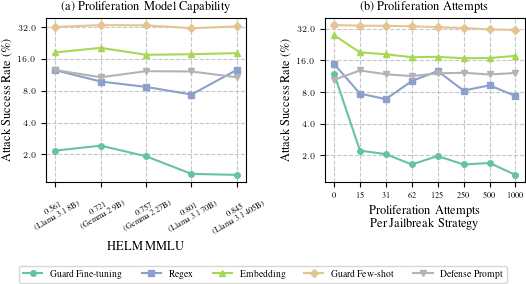

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter, LogLocator

def combined_plots():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.5, 3))  # Adjusted figure size

    # Common variables
    RESPONSES = ['guardfinetuning', 'regex', 'embedding', 'guardfewshot', 'defenseprompt']
    SHOTS = 1
    colors = plt.cm.Set2(np.linspace(0, 1, len(RESPONSES)))
    markers = ['o', 's', '^', 'D', 'v']

    # Plot 1: Proliferation Model
    PROLIFERATION_MODELS = [
        'meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo',
        'google/gemma-2-9b-it',
        'google/gemma-2-27b-it',
        'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
        'meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo',
    ]
    
    HELM_MMLU_SCORES = [
        0.561,
        0.721,
        0.757,
        0.801,
        0.845
    ]
    
    PROLIFERATION_COMPUTE_FRACTION = 1.0

    data1 = []
    for result in raw_results:
        p = result.params
        if (p['proliferation_top_p'] != 1.0 or
                p['proliferation_temperature'] != 1.0 or
                p['proliferation_model'] not in PROLIFERATION_MODELS or
                p['proliferation_compute_fraction'] != PROLIFERATION_COMPUTE_FRACTION or
                p['shots'] != SHOTS or
                p['response'] not in RESPONSES):
            continue
        rj = result.json()

        def avg_asr(suffix):
            num = 0
            denom = 0
            for k, v in rj.items():
                if k.endswith(suffix):
                    num += v['asr']
                    denom += 1
            return num / denom if denom > 0 else 0

        data1.append({
            'response': p['response'],
            'proliferation_model': p['proliferation_model'],
            'avg_asr': (avg_asr('_iid') + avg_asr('_ood')) / 2,
        })
    print(len(data1))
    organized_data1 = {response: {model: [] for model in PROLIFERATION_MODELS} for response in RESPONSES}
    for item in data1:
        organized_data1[item['response']][item['proliferation_model']].append(item)

    avg_data1 = {response: {} for response in RESPONSES}
    for response in RESPONSES:
        for model, items in organized_data1[response].items():
            if items:
                avg_data1[response][model] = sum(item['avg_asr'] for item in items) / len(items)

    x_equidistant1 = range(len(PROLIFERATION_MODELS))

    lines1 = []
    for i, response in enumerate(RESPONSES):
        color = colors[i]
        marker = markers[i]
        asr_y = [avg_data1[response].get(x, np.nan) * 100 for x in PROLIFERATION_MODELS]
        if response == 'guardfinetuning':
            print(response, asr_y)
        line, = ax1.plot(x_equidistant1, asr_y, color=color, linestyle='-', marker=marker,
                         markersize=4, linewidth=1.5)
        lines1.append(line)

    ax1.set_xlabel('HELM MMLU')
    ax1.set_ylabel('Attack Success Rate (\%)')
    ax1.set_title('(a) Proliferation Model Capability')
    ax1.set_xticks(x_equidistant1)
    
    
    def pretty_model(proliferation_model):
        
        idx = PROLIFERATION_MODELS.index(proliferation_model)
        mmlu = HELM_MMLU_SCORES[idx]
        
        pretty = {
            'google/gemma-2-9b-it': "Gemma 2 9B",
            'meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo': "Llama 3.1 8B",
            'google/gemma-2-27b-it': "Gemma 2 27B",
            'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo': "Llama 3.1 70B",
            'meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo': "Llama 3.1 405B",
        }[proliferation_model]
        
        return f"{mmlu}\n({pretty})"
    
    ax1.set_xticklabels([pretty_model(model) for model in PROLIFERATION_MODELS], rotation=30)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_yscale('log')
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.yaxis.set_major_locator(LogLocator(base=2, numticks=15))
    ax1.tick_params(axis='both', which='major', labelsize=6)

    # Plot 2: Proliferation Queries
    compute_fractions = [0, 0.015625]
    while compute_fractions[-1] != 1.0:
        compute_fractions.append(compute_fractions[-1] * 2)

    PROLIFERATION_MODEL = 'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo'
    COMPUTE_FRACTIONS = compute_fractions

    data2 = []
    for result in raw_results:
        p = result.params
        if (p['proliferation_top_p'] != 1.0 or
                p['proliferation_temperature'] != 1.0 or
                p['proliferation_model'] != PROLIFERATION_MODEL or
                p['proliferation_compute_fraction'] not in COMPUTE_FRACTIONS or
                p['shots'] != SHOTS or
                p['response'] not in RESPONSES):
            continue
        rj = result.json()

        def avg_asr(suffix):
            num = 0
            denom = 0
            for k, v in rj.items():
                if k.endswith(suffix):
                    num += v['asr']
                    denom += 1
            return num / denom if denom > 0 else 0

        data2.append({
            'response': p['response'],
            'compute_fraction': p['proliferation_compute_fraction'],
            'avg_asr': (avg_asr('_iid') + avg_asr('_ood')) / 2,
        })
        
    print(len(data2))

    organized_data2 = {response: {fraction: [] for fraction in COMPUTE_FRACTIONS} for response in RESPONSES}
    for item in data2:
        organized_data2[item['response']][item['compute_fraction']].append(item)

    avg_data2 = {response: {} for response in RESPONSES}
    for response in RESPONSES:
        for fraction, items in organized_data2[response].items():
            if items:
                avg_data2[response][fraction] = sum(item['avg_asr'] for item in items) / len(items)

    x_equidistant2 = range(len(COMPUTE_FRACTIONS))

    lines2 = []
    for i, response in enumerate(RESPONSES):
        color = colors[i]
        marker = markers[i % len(markers)]
        asr_y = [avg_data2[response].get(x, np.nan) * 100 for x in COMPUTE_FRACTIONS]
        
        print(response, asr_y)
        
        line, = ax2.plot(x_equidistant2, asr_y, color=color, linestyle='-', marker=marker,
                         markersize=4, linewidth=1.5)
        lines2.append(line)

    ax2.set_xlabel('Proliferation Attempts\nPer Jailbreak Strategy')
    ax2.set_ylabel('Attack Success Rate (\%)')
    ax2.set_title('(b) Proliferation Attempts')
    ax2.set_xticks(x_equidistant2)
    ax2.set_xticklabels([int(i * 1000) for i in COMPUTE_FRACTIONS], rotation=0)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.set_yscale('log')
    ax2.yaxis.set_major_formatter(ScalarFormatter())
    ax2.yaxis.set_major_locator(LogLocator(base=2, numticks=15))
    ax2.tick_params(axis='both', which='major', labelsize=6)
    
    ax1.minorticks_off()
    ax2.minorticks_off()

    # Shared legend
    lines = lines1 + lines2
    labels = LEGEND_LABELS + LEGEND_LABELS
    by_label = dict(zip(labels, lines))
    #     fig.legend(handles, labels, loc='lower center', ncol=len(RESPONSES), bbox_to_anchor=(0.5, 0))

    fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=len(RESPONSES), bbox_to_anchor=(0.5, 0))
    fig.tight_layout()
    plt.subplots_adjust(bottom=0.35)
    # Adjust the layout to make room for the legend
    fig.savefig("plots/proliferation.png", bbox_inches='tight', dpi=300)

# Call the function
combined_plots()

In [ ]:
colors = plt.cm.Set2(np.linspace(0, 1, len(RESPONSES)))
latex_colors = []
for color in colors:
    r, g, b = [int(x * 255) for x in color[:3]]  # Convert 0-1 scale to 0-255
    latex_color = f"{r},{g},{b}"
    latex_colors.append(latex_color)

# Print LaTeX newcommand definitions
for i, color in enumerate(latex_colors):
    print(f"\\newcommand{{\\{LEGEND_LABELS[i]}}}[1]{{\\textcolor[RGB]{{{color}}}{{#1}}}}")


iid gpt-4o-2024-08-06 35.333333333333336
iid meta-llama/Llama-3-8b-chat-hf 28.499999999999996
iid mistralai/Mistral-7B-Instruct-v0.2 56.50000000000001
ood gpt-4o-2024-08-06 42.333333333333336
ood meta-llama/Llama-3-8b-chat-hf 23.5
ood mistralai/Mistral-7B-Instruct-v0.2 48.666666666666664
refusal_rate gpt-4o-2024-08-06 6.7
refusal_rate meta-llama/Llama-3-8b-chat-hf 7.1
refusal_rate mistralai/Mistral-7B-Instruct-v0.2 5.8999999999999995


/tmp/ipykernel_9328/2555153079.py:124: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0.05, 1, 0.97])


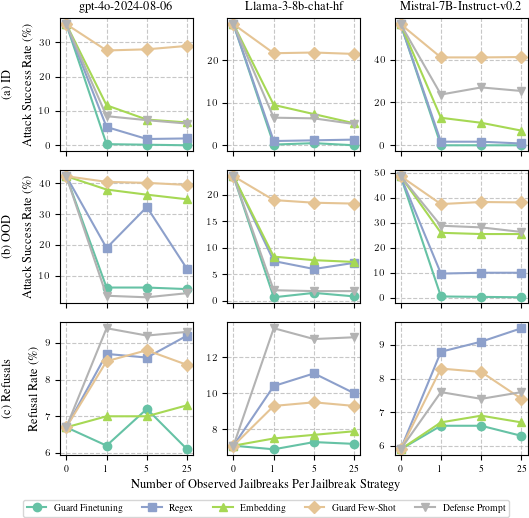

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def fig_models_appendix():
    PROLIFERATION_MODEL = 'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo'
    SHOTS = [0, 1, 5, 25]

    models = ['gpt-4o-2024-08-06',
              'meta-llama/Llama-3-8b-chat-hf',
              'mistralai/Mistral-7B-Instruct-v0.2']

    RESPONSES = ['guardfinetuning', 'regex', 'embedding', 'guardfewshot', 'defenseprompt']
    RESPONSE_TO_LABEL = {
        'guardfinetuning': 'Guard Finetuning',
        'regex': 'Regex',
        'embedding': 'Embedding',
        'guardfewshot': 'Guard Few-Shot',
        'defenseprompt': 'Defense Prompt',
    }

    # Prepare the overall figure and axes
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(5.5, 5.5), sharex='col')

    colors = plt.cm.Set2(np.linspace(0, 1, len(RESPONSES)))
    markers = ['o', 's', '^', 'D', 'v']

    # Define metrics and their corresponding titles and y-labels
    metrics = ['iid', 'ood', 'refusal_rate']
    metric_titles = ['(a) ID', '(b) OOD', '(c) Refusals']
    ylabels = ['Attack Success Rate (\%)', 'Attack Success Rate (\%)', 'Refusal Rate (\%)']

    # Loop over metrics (rows) and models (columns)
    for row_idx, metric in enumerate(metrics):
        for col_idx, model in enumerate(models):
            data = []
            for result in raw_results:
                p = result.params
                if p['proliferation_top_p'] != 1.0 or p['proliferation_temperature'] != 1.0 or p['proliferation_model'] != PROLIFERATION_MODEL or p['proliferation_compute_fraction'] != 1.0:
                    continue
                if p['model'] != model:
                    continue
                rj = result.json()

                def avg_asr(suffix):
                    num = 0
                    denom = 0
                    for k, v in rj.items():
                        if k.endswith(suffix):
                            num += v['asr']
                            denom += 1
                    return num / denom if denom > 0 else np.nan

                data.append(
                    {
                        'response': p['response'],
                        'shots': p['shots'],
                        'iid': avg_asr('_iid'),
                        'ood': avg_asr('_ood'),
                        'refusal_rate': rj.get('easy_refusal_rate', np.nan)
                    }
                )

            organized_data = {response: {value: [] for value in SHOTS} for response in RESPONSES}
            for item in data:
                organized_data[item['response']][item['shots']].append(item)

            # Calculate average ASR for IID and OOD attacks
            avg_data = {response: {} for response in RESPONSES}
            for response in RESPONSES:
                for param_value, items in organized_data[response].items():
                    if items:
                        def avg_over_keys(key):
                            return sum(i[key] for i in items) / len(items)
                        avg_data[response][param_value] = {
                            'iid': avg_over_keys('iid'),
                            'ood': avg_over_keys('ood'),
                            'refusal_rate': avg_over_keys('refusal_rate')
                        }

            # Get the axis for this metric and model
            ax = axes[row_idx, col_idx]

            # Create equidistant x-axis values
            x_equidistant = range(len(SHOTS))

            for i, response in enumerate(RESPONSES):
                color = colors[i]
                marker = markers[i]

                # Line graph for the current metric
                y_values = [avg_data[response].get(x, {}).get(metric, np.nan) * 100 for x in SHOTS]
                if i == 0:
                    print(metric, model, y_values[0])
                ax.plot(x_equidistant, y_values, color=color, linestyle='-', marker=marker,
                        markersize=6, linewidth=1.5, label=RESPONSE_TO_LABEL[response])

            # Customize subplot
            ax.set_xticks(x_equidistant)
            ax.set_xticklabels(SHOTS)

            if row_idx == 0:
                # Add model names at the top of each column
                ax.set_title(model.split('/')[-1])

            if col_idx == 0:
                # Set ylabel only on the first column
                ax.set_ylabel(ylabels[row_idx])

            ax.grid(True, linestyle='--', alpha=0.7)

    # Add metric titles at the start of each row
    for row_idx, metric_title in enumerate(metric_titles):
        # Place the metric title on the left side of the row
        axes[row_idx, 0].annotate(metric_title, xy=(-0.4, 0.5), xycoords='axes fraction', ha='center', va='center', rotation=90)

    # Add a single legend for all subplots at the very bottom
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(RESPONSES), bbox_to_anchor=(0.5, 0))

    # Add a common x-label for all subplots
    fig.text(0.5, 0.06, 'Number of Observed Jailbreaks Per Jailbreak Strategy', ha='center')

    # Adjust layout to make room for the legend and x-label
    fig.tight_layout(rect=[0, 0.05, 1, 0.97])
    fig.subplots_adjust(bottom=0.12)

    # Save the figure
    fig.savefig(f"plots/shots_models_appx.png", bbox_inches='tight', dpi=300)

fig_models_appendix()


/tmp/ipykernel_9328/290895840.py:108: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(rect=[0, 0, 0, 0])
/tmp/ipykernel_9328/290895840.py:108: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 0, 0])


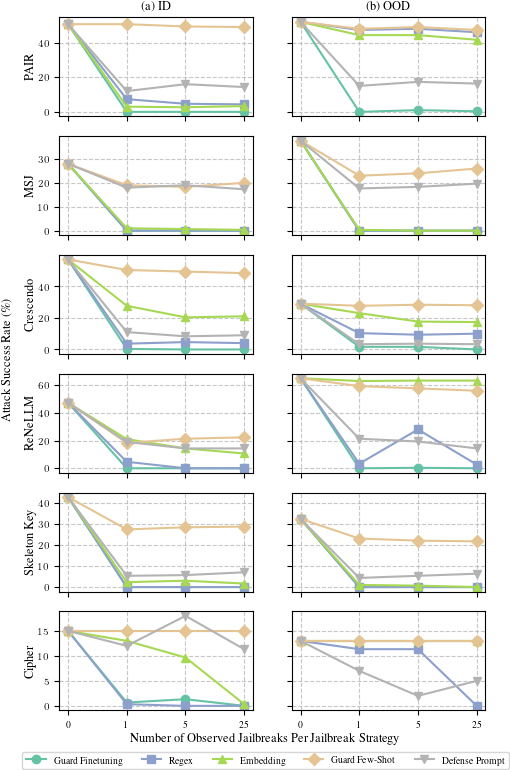

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def fig_attacks_appendix():
    PROLIFERATION_MODEL = 'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo'
    SHOTS = [0, 1, 5, 25]

    RESPONSES = ['guardfinetuning', 'regex', 'embedding', 'guardfewshot', 'defenseprompt']
    RESPONSE_TO_LABEL = {
        'guardfinetuning': 'Guard Finetuning',
        'regex': 'Regex',
        'embedding': 'Embedding',
        'guardfewshot': 'Guard Few-Shot',
        'defenseprompt': 'Defense Prompt',
    }

    ATTACKS = ['pair', 'msj', 'crescendo', 'renellm', 'skeleton_key', 'cipher']

    # Prepare the overall figure and axes with specified width
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(5.5, 9), sharex='col', sharey='row')

    colors = plt.cm.Set2(np.linspace(0, 1, len(RESPONSES)))
    markers = ['o', 's', '^', 'D', 'v']

    # Define metrics and their corresponding titles and y-labels
    metrics = ['iid', 'ood']
    metric_titles = ['(a) ID', '(b) OOD']
    y_label = 'Attack Success Rate (\%)'

    # Collect data
    data = {response: {shots: {attack: {metric: [] for metric in metrics} for attack in ATTACKS} for shots in SHOTS} for response in RESPONSES}

    for result in raw_results:
        p = result.params
        if p['proliferation_top_p'] != 1.0 or p['proliferation_temperature'] != 1.0 or p['proliferation_model'] != PROLIFERATION_MODEL or p['proliferation_compute_fraction'] != 1.0:
            continue
        rj = result.json()
        response = p['response']
        shots = p['shots']

        if response not in RESPONSES or shots not in SHOTS:
            continue

        for attack in ATTACKS:
            for metric in metrics:
                key = f'{attack}_{metric}'
                if key in rj:
                    asr = rj[key]['asr']
                    data[response][shots][attack][metric].append(asr)

    # Compute averages
    avg_data = {response: {shots: {attack: {metric: np.nan for metric in metrics} for attack in ATTACKS} for shots in SHOTS} for response in RESPONSES}

    for response in RESPONSES:
        for shots in SHOTS:
            for attack in ATTACKS:
                for metric in metrics:
                    values = data[response][shots][attack][metric]
                    if values:
                        avg_asr = sum(values) / len(values)
                        avg_data[response][shots][attack][metric] = avg_asr

    # Plotting
    for row_idx, attack in enumerate(ATTACKS):
        for col_idx, metric in enumerate(metrics):
            ax = axes[row_idx, col_idx]

            x_equidistant = range(len(SHOTS))

            for i, response in enumerate(RESPONSES):
                color = colors[i]
                marker = markers[i]

                y_values = [avg_data[response][shots][attack][metric] * 100 if not np.isnan(avg_data[response][shots][attack][metric]) else np.nan for shots in SHOTS]
                ax.plot(x_equidistant, y_values, color=color, linestyle='-', marker=marker,
                        markersize=6, linewidth=1.5, label=RESPONSE_TO_LABEL[response] if row_idx == 0 and col_idx == 0 else None)

            # Customize subplot
            ax.set_xticks(x_equidistant)
            ax.set_xticklabels(SHOTS)

            if row_idx == 0:
                # Add metric titles at the top of each column
                ax.set_title(metric_titles[col_idx])

            if col_idx == 0:
                # Place the attack name vertically on the left side of the row
                
                disp = {
                    'pair': "PAIR",
                    "msj": "MSJ", 
                    "skeleton_key": "Skeleton Key",
                    "renellm": "ReNeLLM",
                }.get(attack, attack.title())
                
                ax.annotate(disp, xy=(-0.15, 0.5), xycoords='axes fraction',
                            ha='center', va='center', rotation=90)

            ax.grid(True, linestyle='--', alpha=0.7)

    # Add a common y-label for all subplots, moved further to the left
    fig.text(0.02, 0.5, y_label, va='center', rotation='vertical')

    # Add a common x-label for all subplots
    fig.text(0.5, 0.075, 'Number of Observed Jailbreaks Per Jailbreak Strategy', ha='center')

    # Adjust layout to make room for the labels and legend
    fig.tight_layout(rect=[0, 0, 0, 0])
    # fig.subplots_adjust(bottom=0.15, left=0.15)

    # Add a single legend for all subplots below the x-label
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(RESPONSES), bbox_to_anchor=(0.5, 0.04))

    # Save the figure
    fig.savefig(f"plots/shots_attacks_appx.png", bbox_inches='tight', dpi=300)

fig_attacks_appendix()


In [120]:
from rapidresponsebench import DEFENSE

PROLIFERATION_MODEL = 'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo'
MODELS = "gpt-4o"

models = list({i.params['model'] for i in raw_results})


print(raw_results[0].params)
defenses = []

for model in models:
    d = DEFENSE.fetch(
        shots=1,
        proliferation_model=PROLIFERATION_MODEL,
        attacks=['cipher', 'crescendo', 'msj', 'pair', 'renellm', 'skeleton_key'],
        proliferation_compute_fraction=1.0,
        proliferation_top_p=1.0,
        proliferation_temperature=1.0,
        response="guardfinetuning",
        model=model
    ).pkl()
    defenses.append(d)



# get the logits 

{'response': 'defenseprompt', 'attacks': ['cipher', 'crescendo', 'msj', 'pair', 'renellm', 'skeleton_key'], 'model': 'mistralai/Mistral-7B-Instruct-v0.2', 'shots': 1, 'proliferation_model': 'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo', 'proliferation_compute_fraction': 0.03125, 'proliferation_top_p': 1.0, 'proliferation_temperature': 1.0}


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
# del defenses
import torch
torch.cuda.empty_cache()

In [83]:
score_data = {}

for d, model in zip(defenses, models):
    d = d.response

    score_data[model] = {'iid': {'benign_scores': [], 'attack_scores': []},
                         'ood': {'benign_scores': [], 'attack_scores': []}}
    refusal = ATTACK.fetch_artifacts(
        attack=f"benign_iid",
        target=model,
        behaviors=f"test_iid"
    )

    benign_scores = []
    for artifact in refusal:
        score = d.p_jailbreak(artifact)
        if artifact.is_policy_refusal:
            score = 1.0
        benign_scores.append(score)

    score_data[model]['iid']['benign_scores'] = benign_scores
    score_data[model]['ood']['benign_scores'] = benign_scores

    for behavior in ['iid', 'ood']:
        # Fetch and compute scores for benign artifacts


        # Fetch and compute scores for attack artifacts
        attack_artifacts = []
        for attack in attacks:
            attack_artifacts.extend(
                ATTACK.fetch_artifacts(
                    attack=f"{attack}_{behavior}",
                    target=model,
                    behaviors=f"test_{behavior}"
                )
            )

        attack_scores = []
        for artifact in attack_artifacts:
            score = d.p_jailbreak(artifact)
            if not artifact.is_policy_jailbreak:
                score = 1.0
            attack_scores.append(score)

        score_data[model][behavior]['attack_scores'] = attack_scores


/tmp/ipykernel_324730/2907089375.py:152: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


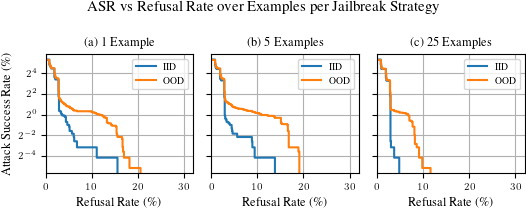

In [42]:
from rapidresponsebench import DEFENSE, ATTACK  # Ensure ATTACK is imported
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

import os
os.environ["FINETUNING_CACHE_ONLY"] = "1"

# Define the proliferation model and initial model list
PROLIFERATION_MODEL = 'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo'

# Extract unique models from raw_results
models = list({i.params['model'] for i in raw_results})

# Define the shots you want to analyze
shots_list = [1, 5, 25]

# Define the attacks list (assuming it's defined somewhere in your code)
attacks = raw_results[0].params["attacks"] # Replace with your actual attacks

# Create a figure with 1 row and 3 columns for the subplots
fig, axes = plt.subplots(1, 3, figsize=(5.5, 2.25), sharex=True, sharey=True)
from bisect import bisect_left
# Iterate over each shots value and corresponding subplot axis
for ax, shots in zip(axes, shots_list):
    defenses = []

    # Fetch defenses for each model with the current shots value
    for model in models:
        d = DEFENSE.fetch(
            shots=shots,
            proliferation_model=PROLIFERATION_MODEL,
            attacks=attacks,
            proliferation_compute_fraction=1.0,
            proliferation_top_p=1.0,
            proliferation_temperature=1.0,
            response="guardfinetuning",
            model=model
        ).pkl()
        defenses.append(d)

    # Initialize score_data for the current shots
    score_data = {}

    # Compute scores for each model
    for d, model in zip(defenses, models):
        d = d.response

        score_data[model] = {'iid': {'benign_scores': [], 'attack_scores': []},
                             'ood': {'benign_scores': [], 'attack_scores': []}}

        # Fetch benign artifacts for IID
        benign_iid = ATTACK.fetch_artifacts(
            attack="benign_iid",
            target=model,
            behaviors="test_iid"
        )

        benign_scores = []
        for artifact in benign_iid:
            score = d.p_jailbreak(artifact)
            if artifact.is_policy_refusal:
                score = 1.0
            benign_scores.append(score)

        score_data[model]['iid']['benign_scores'] = benign_scores
        score_data[model]['ood']['benign_scores'] = benign_scores  # Assuming same benign for OOD

        for behavior in ['iid', 'ood']:
            # Fetch and compute scores for attack artifacts
            attack_artifacts = []
            for attack in attacks:
                attack_artifacts.extend(
                    ATTACK.fetch_artifacts(
                        attack=f"{attack}_{behavior}",
                        target=model,
                        behaviors=f"test_{behavior}"
                    )
                )

            attack_scores = []
            for artifact in attack_artifacts:
                score = d.p_jailbreak(artifact)
                if not artifact.is_policy_jailbreak:
                    score = 1.0
                attack_scores.append(score)

            score_data[model][behavior]['attack_scores'] = attack_scores

    # Initialize aggregation lists for refusal and ASR rates
    agg_refusal = []
    agg_asr = []

    # Process each model's scores
    for behavior in ['iid', 'ood']:
        for model in models:
            benign_scores = sorted(score_data[model][behavior]['benign_scores'])
            attack_scores = sorted(score_data[model][behavior]['attack_scores'])

            refusal_rates = []
            asr_rates = []
            
            for idx, i in enumerate([0] + benign_scores):
                refusal_rate = 1 - idx / len(benign_scores)
                asr = bisect_left(attack_scores, i) / len(attack_scores)

                refusal_rates.append(refusal_rate)
                asr_rates.append(asr)

            agg_refusal.append(refusal_rates)
            agg_asr.append(asr_rates)
    
        # Aggregate the refusal and ASR rates across models
        # Assuming all models have the same refusal rates
        if agg_refusal:
            assert agg_refusal[0] == agg_refusal[1] == agg_refusal[2]

            refusal_rates = [rate * 100 for rate in agg_refusal[0]]
            # Average ASR rates across models
            asr_rates = [np.mean([model_asr[idx] for model_asr in agg_asr]) * 100 for idx in range(len(agg_asr[0]))]
        else:
            refusal_rates = []
            asr_rates = []
    
        # Plot ASR vs Refusal Rate for the current shots
        ax.step(refusal_rates, asr_rates, label=f'{behavior.upper()}', where='post')

    # Add labels, title, and other plot settings
    ax.set_xlabel('Refusal Rate (\%)')
    if ax == axes[0]:
        ax.set_ylabel('Attack Success Rate (\%)')
    
    if shots == 1:
        title = "(a) 1 Example"
    elif shots == 5:
        title = "(b) 5 Examples"
    else:
        title = "(c) 25 Examples"
        
    
    ax.set_title(title)
    ax.set_xlim(0, 32)
    
    ax.set_yscale("log", base=2)
    
    ax.legend()
    ax.grid(True)

# Adjust layout for better spacing

plt.suptitle('ASR vs Refusal Rate over Examples per Jailbreak Strategy')
plt.tight_layout()

plt.savefig(f"plots/roc.png", bbox_inches='tight', dpi=300)
